# Beta Lag Effects

In a traditional cap-m formulation, a security's return is blah blah blah. Lots of people know this. Add this later.

Some people claim beta lag effects exist. I'm here to find out.

## Duff & Phelps Valuation Handbook Methodology

The Duff & Phelps 2016 Valuation Handbook -- Guide to Cost of Capital is commonly cited by valuation experts. It states that a "beta lag" effect exists. A security's return in this period depends on the market return in this period and the security's return in a prior period.

### Lag effects

> **For all but the largest companies, the prices of individual stocks tend to react in part to movements in the overall market with a lag. The smaller the company, generally the greater the lag in the price reaction.** This does not necessarily imply that the market itself is wholly inefficient, although the market for some stocks is more efficient than for other stocks. Large companies tend to be followed by more analysts and are owned by more institutional investors than are small-cap companies. Therefore, large-cap companies tend to react more quickly to changes in the economy or changes in the business.

> Because of the lag […], traditional OLS betas tend to understate systematic risk. A sum beta consists of a multiple regression of a stock's current month's excess returns [...][and] the market's previous month's excess returns, and then a summing of the resulting coefficients. This helps to capture more fully the lagged effect of co-movement in a company's returns with returns on the market.”

Valuators take the concept of Beta qua the concept of Beta, but if material beta lag effects exist, then it should be trivial to estimate future price movements.

Several examples are included from the book:

| Company | Market Cap ($MM) | OLS Beta | Sum Beta | Difference|
|:-------:|:----------------:|:--------:|:--------:|:---------:|
|AT&T, Inc.|211,690.32|0.36|0.36|0.00|
|The Boeing Company|96,872.933|1.01|1.05|0.04|
|FedEx Corporation|41,063.916|1.22|1.3|0.08|
|Lululemon Athletica Inc.|7,269.908|0.81|0.93|0.12|
|Steven Madden, Ltd.|1,891.08|1.02|1.35|0.33|
|Briggs & Stratton Corporation|765.093|1.01|1.36|0.35|
|Almost Family Inc.|375.533|1.42|1.87|0.45|
|StealthGas, Inc.|142.422|1.34|1.57|0.24|

For the \$100MM to \$1B range, it appears as though there is a very significant, positive sum beta.

### Forward Looking Betas

The book argues that, in a predictive sense, betas move toward the market or industry average. Bloomberg and Value Line weight historical betas with the market beta (1.0 by definition) by 2/3 and 1/3, respectively. A more sophisticated technique, Vasicek shrinkage, is also suggested, but not completely explained. It sometimes weights betas to the market average and sometimes to a sector's industry average. Case law and common sense suggest the latter is perhaps more accurate.


### Other Details

For Duff & Phelps, periods are defined as months, but they state that weeks should give similar results. They are based on a five year historical sample. Returns are defined as "excess returns," that is, in excess of the risk free rate. They state that using full returns (rather than excess returns) will produce similar results. Given how stable and low the risk free rate has been lately, I'm skipping this step.

# Full Universe Weekly Beta Calculation
This notebook will study the parameters of 6 different weekly models:

| Dep var: | With Earnings | Without Earnings |
|:--------:|:-------------:|:----------------:|
| ret_cc   | Model 1       | Model 2          |
| ret_oc   | Model 3       | Model 4          |
| ret_co   | Model 5       | Model 6          |

The dependent variable will indicate the beginning and end of the testing period. ret_cc measures from close to close. ret_oc measures from open to close (i.e. while the market is open), etc.

In even numbered models, the weeks of earnings releases and the subsequent weeks are removed from the data set.

Each model will be run over the following time periods:

1. 2011
1. 2012
1. 2013
1. 2014
1. 2015
1. 2011 - 2015

## Key Questions:

1. Does the beta-lag effect exist in all models?
1. Are the companies which display beta-lags consistent from year to year?
1. Is the effect robust to earnings?
1. Does it occur in both large and small companies?

# Setup
## Import Packages

In [1]:
import datetime as dt
import pandas as pd
import numpy as np
from pandas_datareader import data
import statsmodels.formula.api as sm
import time
import wmcm
import seaborn as sns
%matplotlib inline
import pickle
import finsymbols

## Define Universe
The tickers associated with the NYSE and the NASDAQ were pulled using the finsymbols package.

In [2]:
nyse = pd.DataFrame(finsymbols.get_nyse_symbols())
nyse['exchange'] = 'nyse'
nasdaq = pd.DataFrame(finsymbols.get_nasdaq_symbols())
nasdaq['exchange'] = 'nasdaq'
universe = pd.concat([nyse, nasdaq])
universe['symbol'] = universe['symbol'].replace('.', '-')
universe.head()

,company,industry,sector,symbol,exchange
0,3D Systems Corporation,Computer Software: Prepackaged Software,Technology,DDD,nyse
1,3M Company,Medical/Dental Instruments,Health Care,MMM,nyse
2,500.com Limited,Services-Misc. Amusement & Recreation,Consumer Services,WBAI,nyse
3,58.com Inc.,Computer Software: Programming,Technology,WUBA,nyse
4,A.H. Belo Corporation,Newspapers/Magazines,Consumer Services,AHC,nyse


## Pull Universe

In [3]:
# Uncomment these lines the first time notebook run on computer. Full price data isn't uploaded to github.

# stocks = wmcm.Universe(universe['symbol'], 'SPY', interval='w', verbose=False)
# output = open('pickle/full_price_history.p', 'wb')
# pickle.dump(stocks, output)
# output.close()

pkl_file = open('pickle/full_price_history.p', 'rb')
stocks = pickle.load(pkl_file)
pkl_file.close()

In [4]:
stocks['GOOG']

Stock : GOOG
        Starting Date : 2011-01-01 00:00:00
        Ending Date : 2015-12-31 00:00:00
        Frequency : w

In [5]:
stocks['YCB']

Stock : YCB
        Starting Date : 2011-01-01 00:00:00
        Ending Date : 2015-12-31 00:00:00
        Frequency : w

## Prepare Analysis Dataframes

In [6]:
for key in list(stocks.keys()): #list(stock.keys()) allows you to delete while iterating
    if key=='market':
        continue
    if len(stocks[key].earnings_df.index)==0: # Have to remove stocks without earnings.
        del stocks[key]
    else:
        stocks[key].analysis_df = stocks[key].adj_returns
        stocks[key].analysis_df['lagged_ret_cc'] = stocks[key].analysis_df['ret_cc'].shift(1)
        stocks[key].analysis_df = stocks[key].analysis_df.loc[(stocks[key].analysis_df['earnings_period'].shift(1)==False)]

stocks['market'].analysis_df = stocks['market'].adj_returns

# Fit Models
## Model 1

In [7]:
def add_m_cap(df):
    df['market_cap'] = df.index.map(lambda x : stocks[x].market_cap)
    df['units'] = df['market_cap'].astype('str').str[-1:]
    df['market_cap'] = df['market_cap'].astype('str').str[:-1]
    
    df['new_units'] = np.nan
    df.loc[df['units'] == 'B', 'new_units'] = 1000000000
    df.loc[df['units'] == 'M', 'new_units'] = 1000000
    
    df['new_market_cap'] = pd.to_numeric(df['market_cap'], errors = 'coerce')
    
    df['new_market_cap'] = df['new_market_cap'] * df['new_units']
    
    df['market_cap'] = df['new_market_cap']
    df.drop(['units', 'new_units', 'new_market_cap'], axis = 1, inplace = True)
    df.columns = ['t_val', 'market_cap']
    return df

using a non-integer number instead of an integer will result in an error in the future


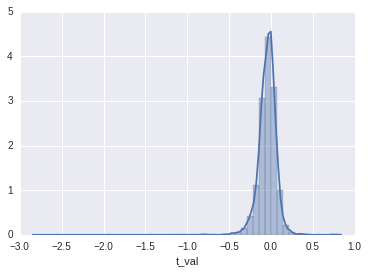

In [8]:
stocks.factor_model_all('ret_cc ~ ret_cc_market + lagged_ret_cc', filter_earnings=False)
stocks.model_1 = stocks.results
plot_data = pd.DataFrame({stock : stocks.model_1[stock].params[2] for stock in stocks.keys() if stock != 'market'}, index=[0])
plot_data = plot_data.transpose()
plot_data = add_m_cap(plot_data)
sns.distplot(plot_data['t_val'])

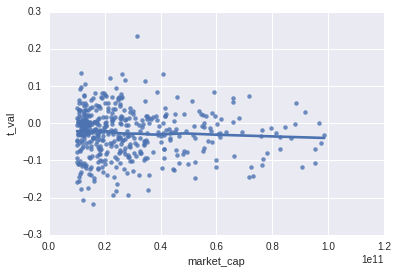

In [12]:
sns.regplot(x='market_cap', y='t_val', data=plot_data.loc[(plot_data['market_cap']<1e11) & (plot_data['market_cap']>1e10)], lowess=True)

## Model 2

using a non-integer number instead of an integer will result in an error in the future


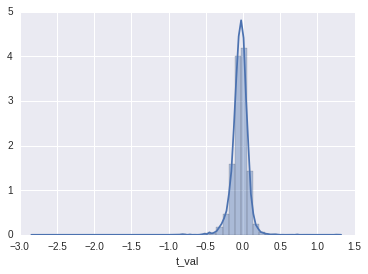

In [34]:
stocks.factor_model_all('ret_cc ~ ret_cc_market + lagged_ret_cc', filter_earnings=True)
stocks.model_2 = stocks.results
plot_data = pd.DataFrame({stock : stocks.model_2[stock].params[2] for stock in stocks.keys() if stock != 'market'}, index=[0])
plot_data = plot_data.transpose()
plot_data = add_m_cap(plot_data)
plot_data = plot_data.loc[plot_data['market_cap'].notnull()]
sns.distplot(plot_data['t_val'])

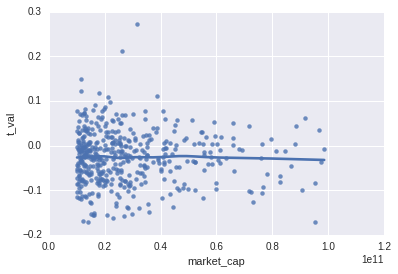

In [35]:
sns.regplot(x='market_cap', y='t_val', data=plot_data.loc[(plot_data['market_cap']<1e11) & (plot_data['market_cap']>1e10)], lowess=True)

## Model 3

using a non-integer number instead of an integer will result in an error in the future


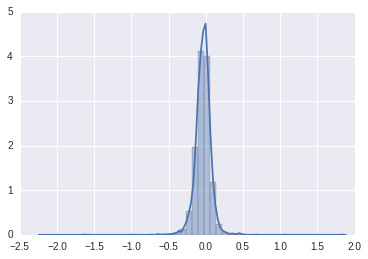

In [9]:
stocks.factor_model_all('ret_oc ~ ret_oc_market + lagged_ret_cc', filter_earnings=False)
stocks.model_3 = stocks.results
stocks.model_3['GOOG'].params
plot_data = pd.DataFrame({stock : stocks.model_3[stock].params[2] for stock in stocks.keys() if stock != 'market'}, index=[0])
plot_data = plot_data.transpose()
sns.distplot(plot_data)

## Model 4

using a non-integer number instead of an integer will result in an error in the future


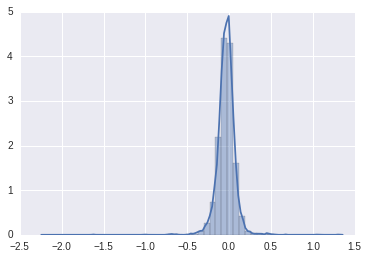

In [10]:
stocks.factor_model_all('ret_oc ~ ret_oc_market + lagged_ret_cc', filter_earnings=True)
stocks.model_4 = stocks.results
stocks.model_4['GOOG'].params
plot_data = pd.DataFrame({stock : stocks.model_4[stock].params[2] for stock in stocks.keys() if stock != 'market'}, index=[0])
plot_data = plot_data.transpose()
sns.distplot(plot_data)

## Model 5

using a non-integer number instead of an integer will result in an error in the future


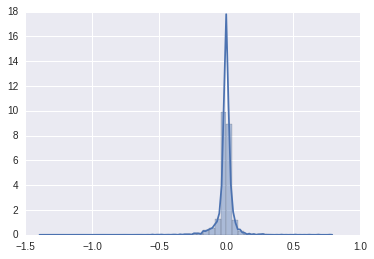

In [11]:
stocks.factor_model_all('ret_co ~ ret_co_market + lagged_ret_cc', filter_earnings=False)
stocks.model_5 = stocks.results
stocks.model_5['GOOG'].params
plot_data = pd.DataFrame({stock : stocks.model_5[stock].params[2] for stock in stocks.keys() if stock != 'market'}, index=[0])
plot_data = plot_data.transpose()
sns.distplot(plot_data)

## Model 6

using a non-integer number instead of an integer will result in an error in the future


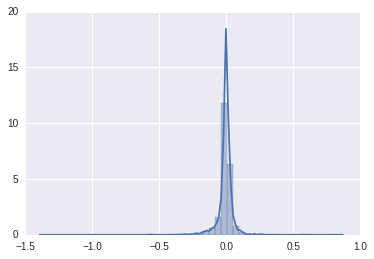

In [12]:
stocks.factor_model_all('ret_co ~ ret_co_market + lagged_ret_cc', filter_earnings=True)
stocks.model_6 = stocks.results
stocks.model_6['GOOG'].params
plot_data = pd.DataFrame({stock : stocks.model_6[stock].params[2] for stock in stocks.keys() if stock != 'market'}, index=[0])
plot_data = plot_data.transpose()
sns.distplot(plot_data)

# Analysis
## Robustness Check

Based on the whole-universe histograms, it appears as though, unlike the examples shown in the D&P textbook, the beta-lag coefficients are tightly distributed around zero. This appears to be the case across all models. Before doing anything else, I'm curious how robust the D&P estimates are to the implemented model specification (weeks instead of months). Model 1 is displayed across the following stocks.

### Lululemon Athletica Inc. (LULU)

In [13]:
stocks.model_1['LULU'].params

Intercept       -0.000590
ret_cc_market    1.220327
lagged_ret_cc   -0.108409
dtype: float64

In [14]:
stocks.model_1['LULU'].tvalues

Intercept       -0.160835
ret_cc_market    6.613079
lagged_ret_cc   -1.600283
dtype: float64

### Steven Madden, LTD. (SHOO)

In [15]:
stocks.model_1['SHOO'].params

Intercept       -0.000242
ret_cc_market    1.126691
lagged_ret_cc   -0.127502
dtype: float64

In [16]:
stocks.model_1['SHOO'].tvalues

Intercept       -0.102660
ret_cc_market    9.626318
lagged_ret_cc   -2.234113
dtype: float64

### Briggs & Stratton Corporation (BGG)

In [17]:
stocks.model_1['BGG'].params

Intercept       -0.003951
ret_cc_market    1.346291
lagged_ret_cc   -0.059646
dtype: float64

In [18]:
stocks.model_1['BGG'].tvalues

Intercept        -1.871988
ret_cc_market    12.304669
lagged_ret_cc    -1.041728
dtype: float64

### Almost Family Inc. (AFAM)

In [19]:
stocks.model_1['AFAM'].params

Intercept       -0.000738
ret_cc_market    1.257646
lagged_ret_cc   -0.057361
dtype: float64

In [20]:
stocks.model_1['AFAM'].tvalues

Intercept       -0.222757
ret_cc_market    7.623387
lagged_ret_cc   -0.809474
dtype: float64

### StealthGas, Inc. (GASS)

In [21]:
stocks.model_1['GASS'].params

Intercept       -0.005185
ret_cc_market    1.136124
lagged_ret_cc    0.087225
dtype: float64

In [22]:
stocks.model_1['GASS'].tvalues

Intercept       -1.705856
ret_cc_market    7.483085
lagged_ret_cc    1.514782
dtype: float64

Most of these lagged t-values do not appear to be significant and fall on both sides of zero.

At this point, I'm curious if the concept of "sum beta" has any validity in valuation. I need to refactor with only models 1 and 2, add a measure of market cap so I can focus on particular universes of stocks and run F-tests to see if the lagged_ret_cc variable should be included in beta. If it can, then we can use it to make infinite money in the stock market. If it can't, then I can acheive notoriety by disproving a valuation concept. Muahahahahaha.

# Experiment to look at market cap

In [23]:
stocks_test = wmcm.Universe(['LULU', 'AFAM', 'GASS'], 'SPY', interval = 'w', verbose = False)

In [24]:
stocks_test['AFAM'].market_cap

'447.81M'